# Marijuana Legalization and Violent Crime

> Daniela Jiménez Lara (dj216)

In recent years, many US states have decided to legalize the use of marijuana. 

When these ideas were first proposed, there were many theories about the relationship between crime and the "War on Drugs" (the term given to US efforts to arrest drug users and dealers over the past several decades). 

In this exercise, we're going to test a few of those theories using drug arrest data from the state of California. 

Though California has passed a number of laws lessening penalities for marijuana possession over the years, arguably the biggest changes were in  2010, when the state changed the penalty for possessing a small amount of marijuana from a criminal crime to a "civil" penality (meaning those found guilty only had to pay a fine, not go to jail), though possessing, selling, or producing larger quantities remained illegal. Then in 2016, the state fully legalized marijuana for recreational use, not only making possession of small amounts legal, but also creating a regulatory system for producing marijuana for sale. 

Proponents of drug legalization have long argued that the war on drugs contributes to violent crime by creating an opportunity for drug dealers and organized crime to sell and distribute drugs, a business which tends to generate violence when gangs battle over territory. According to this theory, with drug legalization, we should see violent crime decrease after legalization in places where drug arrests had previously been common. 

**To be clear,** this is far from the only argument for drug legalization! It is simply the argument we are well positioned to analyze today. 

(Students from Practical Data Science: This should sound familiar! Last semester we did this analysis in a very simple, crude manner; in this class we'll do it rigorously with your new found difference-in-differences skills!)

## Exercise 1

Download and import California arrest data from [https://www.github.com/nickeubank/MIDS_Data/UDS_arrest_data.csv](https://www.github.com/nickeubank/MIDS_Data/UDS_arrest_data.csv). What is a unit of observation (a single row) in this data? What entities are being tracked, and over what time period? (This data is derived from raw California arrest data from the State Attorney General's office [here](https://openjustice.doj.ca.gov/data), in the "Arrests" category.)

Note that `VIOLENT` is a count of arrests for violent offenses, and `F_DRUGOFF` is a count of felony drug arrests. `total_population` is total population. 

In [1]:
import pandas as pd

df = pd.read_csv(
    "https://github.com/nickeubank/MIDS_Data/raw/master/UDS_arrest_data.csv"
)

The unit of observation is county per year.
The entities are California counties.
The time period is 1980 to 2018.

In [2]:
df.describe()

,YEAR,VIOLENT,F_DRUGOFF,total_population
count,2262.000000,2262.000000,2262.000000,2.262000e+03
mean,1999.000000,2084.767462,2063.761273,5.611930e+05
std,11.257117,5695.691031,5816.478130,1.297315e+06
min,1980.000000,1.000000,0.000000,1.097000e+03
25%,1989.000000,145.000000,109.000000,4.208128e+04
50%,1999.000000,516.000000,399.500000,1.525506e+05
75%,2009.000000,1925.500000,1498.250000,5.144530e+05
max,2018.000000,64790.000000,69667.000000,9.818605e+06


## Exercise 2

In this analysis, we will split our sample into "treated" and "control" on the basis of whether a given county had a high average drug arrest rate in the three years before California began drug legalization in 2010. Counties with high drug arrest rates, after all, will be more impacted by drug liberalization policies. 

Calculate each county's average drug arrest *rate* for the period from 2007-2009. Then calculate the median value across counties, and create an indicator called `treated` for counties whose average drug arrest rate during this period was above the median average drug arrest rate. In other words, half your counties should be in the "treated" group, and half in "control". 

Note that this indicator should be *time-invariant*—if a county is in the treated group, it should always be identified as being in the treated group. 

In [3]:
import numpy as np

df["arrest_rate"] = df["F_DRUGOFF"] / df["total_population"]

df_07_10 = df[df["YEAR"].isin([2007, 2008, 2009])].copy()

df_07_10_g = (
    df_07_10.groupby("COUNTY")["arrest_rate"]
    .mean()
    .reset_index()
    .rename(columns={"arrest_rate": "avg_drug_arrest_rate_0709"})
)


df_07_10_g["treated"] = (
    df_07_10_g["avg_drug_arrest_rate_0709"]
    > df_07_10_g["avg_drug_arrest_rate_0709"].median()
)

In [4]:
df_07_10_g["treated"].value_counts()

treated
True     29
False    29
Name: count, dtype: int64

## Exercise 3

Our outcome in this analysis is the violent arrest rate -- if drug liberalization reduces crime overall, we would expect to see this rate fall in counties with high drug arrest rates after liberalization; if not, we would not expect to see any changes. Create a `violent_rate` variable with is violent arrests per 100,000 people. 

In [5]:
df["violent_rate"] = df["VIOLENT"] / df["total_population"] * 100000
df = df.merge(df_07_10_g, how="left", on="COUNTY")
df

,YEAR,COUNTY,VIOLENT,F_DRUGOFF,total_population,arrest_rate,violent_rate,avg_drug_arrest_rate_0709,treated
0,1980,Alameda County,4504,3569,1105379.0,0.003229,407.462056,0.003945,True
1,1981,Alameda County,4699,3926,1122759.3,0.003497,418.522474,0.003945,True
2,1982,Alameda County,4389,4436,1140139.6,0.003891,384.952860,0.003945,True
3,1983,Alameda County,4500,5086,1157519.9,0.004394,388.762215,0.003945,True
4,1984,Alameda County,3714,5878,1174900.2,0.005003,316.111956,0.003945,True
...,...,...,...,...,...,...,...,...,...
2257,2014,Yuba County,392,329,72155.0,0.004560,543.274894,0.003516,True
2258,2015,Yuba County,454,194,72155.0,0.002689,629.201026,0.003516,True
2259,2016,Yuba County,491,154,72155.0,0.002134,680.479523,0.003516,True
2260,2017,Yuba County,464,121,72155.0,0.001677,643.060079,0.003516,True


## Exercise 4

Differences-in-differences get their name from the fact that the estimator, in its most basic implementation, is just the difference between:

-  difference in the average change in outcome among eventually-treated units from before to after when treatment is applied, and
-  difference in the average change in outcome among never-treated units from before to after when treatment (to the treated units). 

(Obviously treatment is never a applied to the never-treated units -- when we talk about pre / post, we refer to before and after the point in time in which treatment is applied to the treated units. So if treated units are treated in 2008, then for the never-treated units, we are also comparing outcomes before 2008 to after 2008, even though 2008 has no special significance for the never-treated units). 

In its most basic implementation, therefore, calculating a difference-in-difference estimate requires calculating just 4 numbers:

- $\bar y_{T=1,Post}$  Avg for Treatment, Post-Treatment
- $\bar y_{T=0,Post}$  Avg for Control, Post-Treatment
- $\bar y_{T=1,Pre}$   Avg for Treatment, Pre-Treatment
- $\bar y_{T=0,Pre}$   Avg for Control, Pre-Treatment

The difference-in-differences estimator $\hat \delta$  is defined as

$$
\hat{\delta}= (\bar{y}_{T=1,\,Post}-\bar{y}_{T=1,\,Pre})-(\bar{y}_{T=0,\,Post}-\bar{y}_{T=0,\,Pre})
$$



Calculate (a) the change in violent arrest rates for our treated groups from before legalization to after ($\bar y_{T=1,Post} - \bar y_{T=1, Pre}$), and (b) our difference in difference estimator $\hat\delta$ by calculating these four values. Does doing your difference-in-difference estimate tell you something different from what you'd learn if you had just done a pre-post comparison?

For the `Pre` period, consider the three years before liberalization begins in 2010 (e.g. 2007-2009). For the `Post` period, consider the three years after final legalization took place (2016-2018). We will ignore the middle period in which marijuana was decriminalized but not yet legal. 

In [6]:
import warnings

warnings.filterwarnings("ignore")

df.loc[(df["YEAR"] >= 2007) & (df["YEAR"] <= 2009), "time"] = "pre"
df.loc[(df["YEAR"] >= 2016) & (df["YEAR"] <= 2018), "time"] = "post"

violent_arrest_treated_pre = df[(df["time"] == "pre") & (df["treated"] == 1)][
    "violent_rate"
].mean()
violent_arrest_treated_post = df[(df["time"] == "post") & (df["treated"] == 1)][
    "violent_rate"
].mean()
violent_arrest_control_pre = df[(df["time"] == "pre") & (df["treated"] == 0)][
    "violent_rate"
].mean()
violent_arrest_control_post = df[(df["time"] == "post") & (df["treated"] == 0)][
    "violent_rate"
].mean()

delta_violent_arrest_treated = violent_arrest_treated_post - violent_arrest_treated_pre
delta_violent_arrest_control = violent_arrest_control_post - violent_arrest_control_pre


dif_dif = delta_violent_arrest_treated - delta_violent_arrest_control

print(
    f"Average violent arrests rate in control counties, pre-treatment: {violent_arrest_control_pre:,.2f} per 100,000 people"
)
print(
    f"Average violent arrests rate in control counties, post-treatment: {violent_arrest_control_post:,.2f} per 100,000 people"
)
print(
    f"Average violent arrests rate in treatment counties, pre-treatment: {violent_arrest_treated_pre:,.2f} per 100,000 people"
)
print(
    f"Average violent arrests rate in treatment counties, post-treatment: {violent_arrest_treated_post:,.2f} per 100,000 people"
)

print(
    f"Change in violent arrest rates for treated groups from before legalization to after: {delta_violent_arrest_treated:,.2f} "
)

print(
    f"\nDifference-in-Difference Estimator: {dif_dif:,.2f} arrests per 100,000 people"
)

Average violent arrests rate in control counties, pre-treatment: 319.78 per 100,000 people
Average violent arrests rate in control counties, post-treatment: 300.40 per 100,000 people
Average violent arrests rate in treatment counties, pre-treatment: 426.61 per 100,000 people
Average violent arrests rate in treatment counties, post-treatment: 399.81 per 100,000 people
Change in violent arrest rates for treated groups from before legalization to after: -26.80 

Difference-in-Difference Estimator: -7.42 arrests per 100,000 people


> If we only used a pre-post analysis, there appears to be a substantial reduction of 26.8 arrests per 100,000 people. However, the Diff-in-Diff analysis shows a lower reduction of 7.42 arrests per 100,000 people. These difference in results suggests that the pre-post analysis would lead to an overestimation of the policy's actual impact on violent crime rates.
The reason for this disparity lies in the fact that the pre-post analysis can only account the general decreasing trend of violent crimes observed both before and after the policy implementation. By contrast, the Diff-in-Diff approach adjusts this trend by comparing the differences between treated and control groups over time, where treatment considers if a given county had a high average drug arrest rate in the three years before California began drug legalization in 2010. Counties with high drug arrest rates, will be more impacted by drug liberalization policies. 

## Exercise 5

Now calculate $\hat\delta$ using a regression with an indicator for post-2010, an indicator for treated, and an interaction of the two. Use only the same set of years you used above. How does your estimate compare to the estimate you calculated in Exercise 4?

What does this tell you about interpretation of interaction terms with two indicator variables?

Note: You need to cluster your standard errors by county, since we expect counties (over time) to be subject to common fluctuations. 

In [7]:
df_07_10_t_nt = df[df["time"].notna()].copy()
df_07_10_t_nt["post"] = df_07_10_t_nt["time"] == "post"

In [8]:
import statsmodels.formula.api as smf

smf.ols("violent_rate ~ post + treated + post*treated", data=df_07_10_t_nt).fit(
    cov_type="cluster", cov_kwds={"groups": df_07_10_t_nt["COUNTY"]}
).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           violent_rate   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.214
Method:                 Least Squares   F-statistic:                     11.00
Date:                Mon, 22 Apr 2024   Prob (F-statistic):           8.45e-06
Time:                        12:38:06   Log-Likelihood:                -2094.1
No. Observations:                 348   AIC:                             4196.
Df Residuals:                     344   BIC:                             4212.
Df Model:                           3                                         
Covariance Type:              cluster                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                      319.7820     17.638     18.131      0.000     285.213     354.351
post[T.True]                   -19.3816      9.892     -1.959      0.050     -38.769       0.005
treated[T.True]                106.8289     23.385      4.568      0.000      60.995     152.663
post[T.True]:treated[T.True]    -7.4181     18.869     -0.393      0.694     -44.401      29.565
==============================================================================
Omnibus:                       53.945   Durbin-Watson:                   0.741
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               81.621
Skew:                           0.965   Prob(JB):                     1.89e-18
Kurtosis:                       4.380   Cond. No.                         6.85
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

> The coefficient obtained for the interaction term in the regrssion and the estimator obtained with the diff and diff method are the same: -7.42. 

> This indicates that a diff and diff method and calculating the coefficient between a treatment and pre-post period, via their interaction in a regression, are parallel methods delivering the same result. Additonally, the regression gives us the statistical significance of this calculation (via the p-value), which in this case is not signifcant.

## Exercise 6

In the preceding exercise, we did a simple pre-post / treated-control comparison. But one important limitation of these designs is that they do not allow us to test for *parallel trends*. 

**Plot** a difference-in-difference model using data from 2000-2009 (inclusive) and from 2016-2018 (inclusive). Note this will have four different geometric components: a time trend for treated counties pre-2010, a time trend for control counties pre-2010, a time trend for treated counties post-2016 (include 2016), and a time trend for control counties post-2016 (include 2016). 

Do you see evidence of parallel trends for these two datasets? Does that make you feel more or less confident in your diff-in-diff estimates?

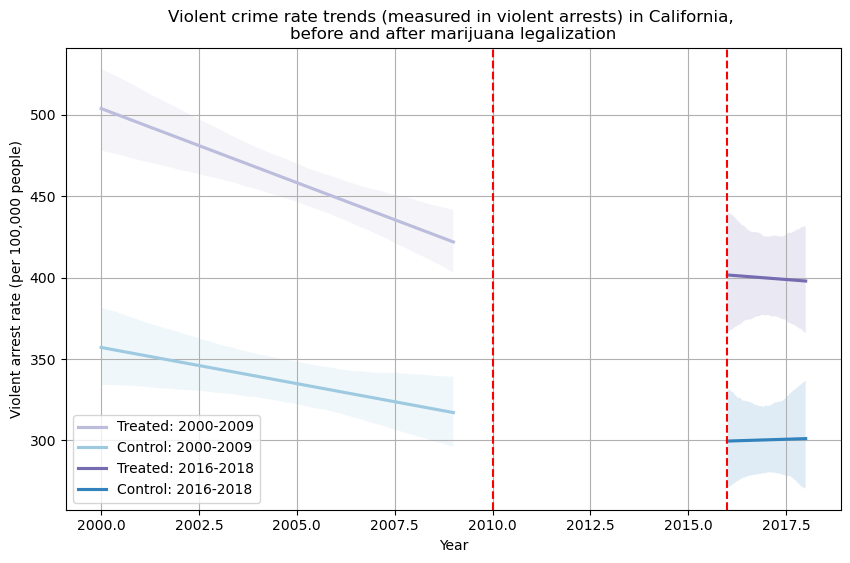

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt


treated_00_09 = df[(df["treated"] == 1) & (df["YEAR"] >= 2000) & (df["YEAR"] <= 2009)]
treated_16_18 = df[(df["treated"] == 1) & (df["YEAR"] >= 2016) & (df["YEAR"] <= 2018)]
control_00_09 = df[(df["treated"] == 0) & (df["YEAR"] >= 2000) & (df["YEAR"] <= 2009)]
control_16_18 = df[(df["treated"] == 0) & (df["YEAR"] >= 2016) & (df["YEAR"] <= 2018)]

plt.figure(figsize=(10, 6))

sns.regplot(
    x="YEAR",
    y="violent_rate",
    data=treated_00_09,
    scatter=False,
    label="Treated: 2000-2009",
    color="#bcbddc",
)
sns.regplot(
    x="YEAR",
    y="violent_rate",
    data=control_00_09,
    scatter=False,
    label="Control: 2000-2009",
    color="#9ecae1",
)

sns.regplot(
    x="YEAR",
    y="violent_rate",
    data=treated_16_18,
    scatter=False,
    label="Treated: 2016-2018",
    color="#756bb1",
)
sns.regplot(
    x="YEAR",
    y="violent_rate",
    data=control_16_18,
    scatter=False,
    label="Control: 2016-2018",
    color="#3182bd",
)
plt.axvline(x=2010, color="red", linestyle="--")
plt.axvline(x=2016, color="red", linestyle="--")

plt.xlabel("Year")
plt.ylabel("Violent arrest rate (per 100,000 people)")
plt.title(
    "Violent crime rate trends (measured in violent arrests) in California, \nbefore and after marijuana legalization"
)

plt.legend()

plt.grid(True)
plt.show()

> By ploting our data, we can see the parallel trends between treatment and control groups in the pre-marijuana legalization period. This gives us confidence in our diff and diff analysis.  For the post period we can observe how the treatment group has a decline in arrests, while the control group has the opposite trend. 

## Exercise 7

While we can estimate the model described above precisely as a regression, it's actually much easier to estimate a more flexible model by running the regression we ran in Exercise 5 but with both `county` and `year` fixed effects. Use `PanelOLS` (or `lfe` in R) to estimate this fixed effects regression. 

With all these additional fixed effects, do you find evidence that marijuana legalization reduced violent crime?

In [10]:
df_07_10_t_nt["treated_and_post"] = df_07_10_t_nt["treated"] * df_07_10_t_nt["post"]
df_07_10_t_nt.set_index(["COUNTY", "YEAR"], inplace=True)

In [11]:
import linearmodels as lm

lm.PanelOLS.from_formula(
    "violent_rate  ~  treated_and_post +  EntityEffects + TimeEffects ",
    data=df_07_10_t_nt,
).fit()

Dep. Variable:,violent_rate,R-squared:,0.0013
Estimator:,PanelOLS,R-squared (Between):,-0.0109
No. Observations:,348,R-squared (Within):,0.0155
Date:,"Mon, Apr 22 2024",R-squared (Overall):,-0.0104
Time:,12:38:07,Log-likelihood,-1858.7
Cov. Estimator:,Unadjusted,,
,,F-statistic:,0.3829
Entities:,58,P-value,0.5366
Avg Obs:,6.0000,Distribution:,"F(1,284)"
Min Obs:,6.0000,,
Max Obs:,6.0000,F-statistic (robust):,0.3829


> With the additional fixed effects, we obtained the same coefficient as the diff and diff method and the regression with interaction terms. Although the coefficient of this model shows a decrease in violent arrests, the significance level of this change is still statistcally low per the p-vaue (0.5366). With this result we do not find evidence that marijuana legalization reduced violent crime. 
